# DLS Предсказание оттока пользователей

## Импорт библиотек

In [2]:
!pip install -q catboost
!pip install -q optuna

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, normalize, StandardScaler
from sklearn import linear_model
from sklearn import ensemble 
from sklearn import model_selection
from sklearn import metrics
import catboost
import optuna

%matplotlib inline
# to be continued...

In [4]:
RANDOM_STATE = 42

## Посмотрим на данные

In [5]:
train_df = pd.read_csv("/kaggle/input/advanced-dls-spring-2021/train.csv")
test_df = pd.read_csv("/kaggle/input/advanced-dls-spring-2021/test.csv")
sample_submission = pd.read_csv("/kaggle/input/advanced-dls-spring-2021/submission.csv")

In [6]:
train_df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [7]:
sample_submission.head()

,Id,Churn
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [8]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [10]:
train_df[train_df.duplicated(keep=False)]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
7,1,45.70,45.7,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
170,1,69.90,69.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
329,1,69.35,69.35,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
409,1,69.60,69.6,Female,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
594,1,20.05,20.05,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
838,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1068,1,70.15,70.15,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
1217,1,20.20,20.2,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,1
1236,1,45.30,45.3,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,1
1384,1,69.90,69.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1


In [11]:
target = train_df[target_col]
train_df = train_df.drop('Churn', axis=1).drop_duplicates(keep=False)
train_df[target_col] = target

### Целевая переменная

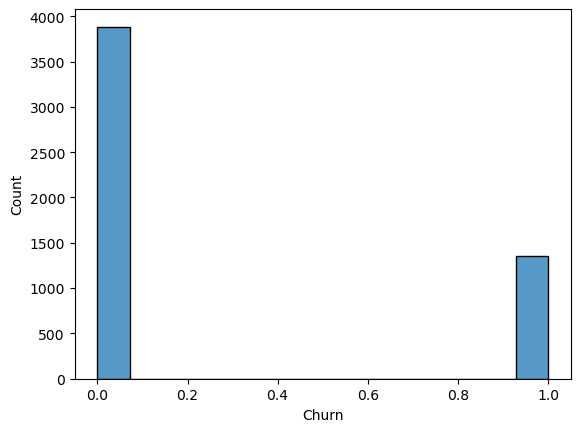

In [12]:
sns.histplot(data=train_df, x="Churn");

Классы не сбалансированны

### TotalSpent

In [13]:
def is_not_convertable(x):
  try:
    x = float(x)
    return False
  except:
    return True

no_tot_sp = train_df[train_df['TotalSpent'].apply(lambda x: is_not_convertable(x))]
print(no_tot_sp.shape[0])
no_tot_sp.head()

9


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0


In [14]:
zero_cp = train_df[train_df.ClientPeriod == 0]
zero_cp.equals(no_tot_sp)

True

Заметим, что в TotalSpent не указаны затраты людей, у которых ClientPeriod = 0
Будем считать, что они потратили 0

In [15]:
train_df.replace(" ", np.nan, inplace=True)
test_df.replace(" ", np.nan, inplace=True)
train_df["TotalSpent"] = train_df['TotalSpent'].fillna(0).astype(float)
test_df["TotalSpent"] = test_df['TotalSpent'].fillna(0).astype(float)

### Числовые признаки

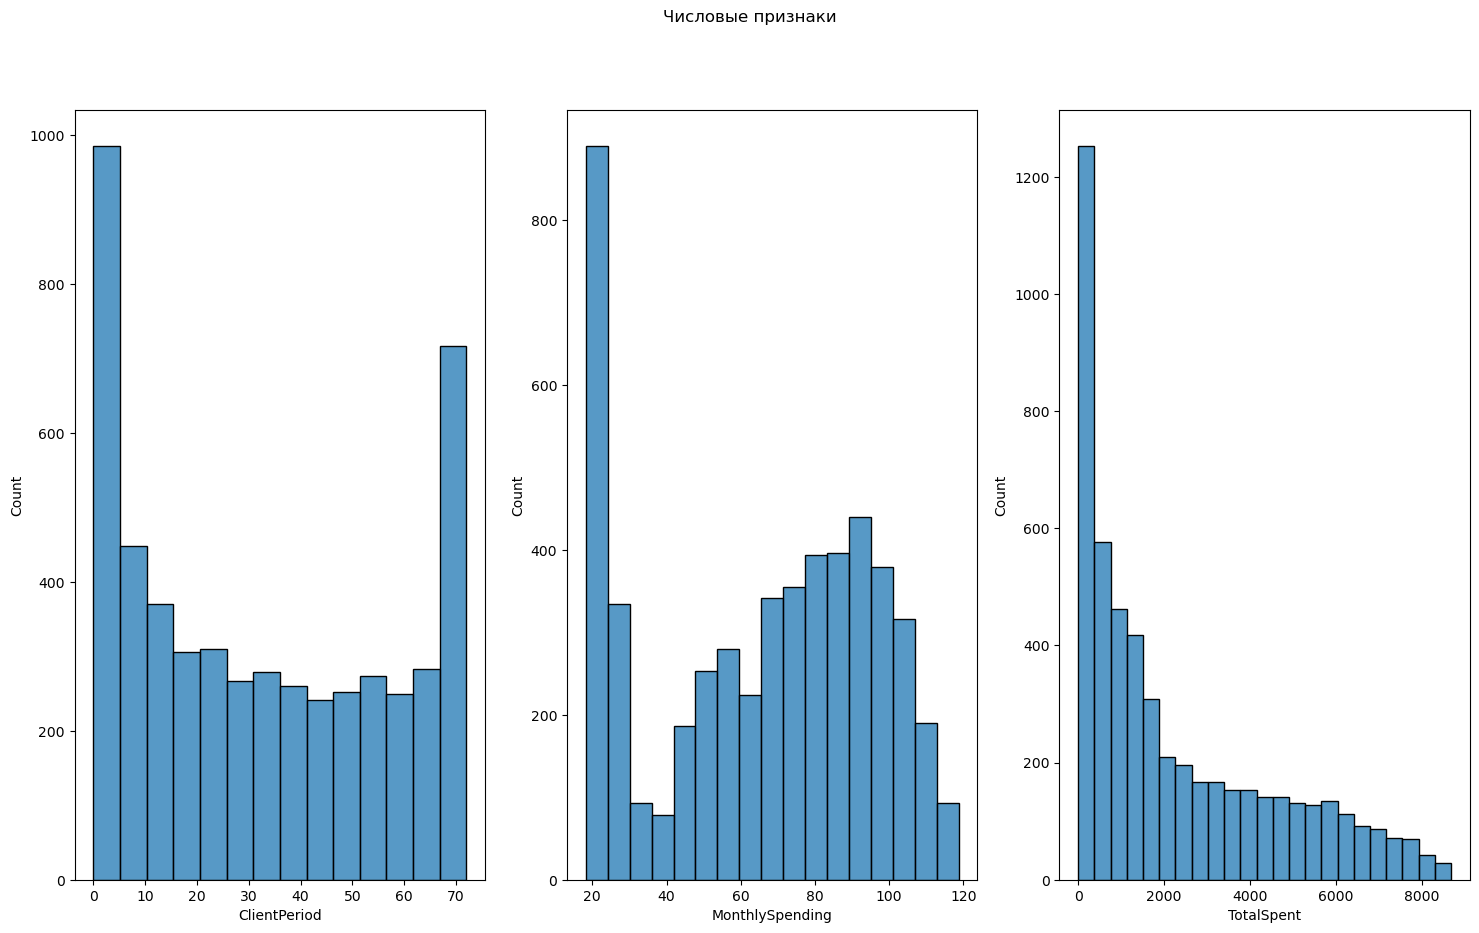

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

fig.suptitle("Числовые признаки")

sns.histplot(ax=axes[0], data=train_df, x="ClientPeriod")
sns.histplot(ax=axes[1], data=train_df, x="MonthlySpending")
sns.histplot(ax=axes[2], data=train_df, x="TotalSpent")

fig.show();

### Категориальные признаки

In [17]:
len(cat_cols)

16

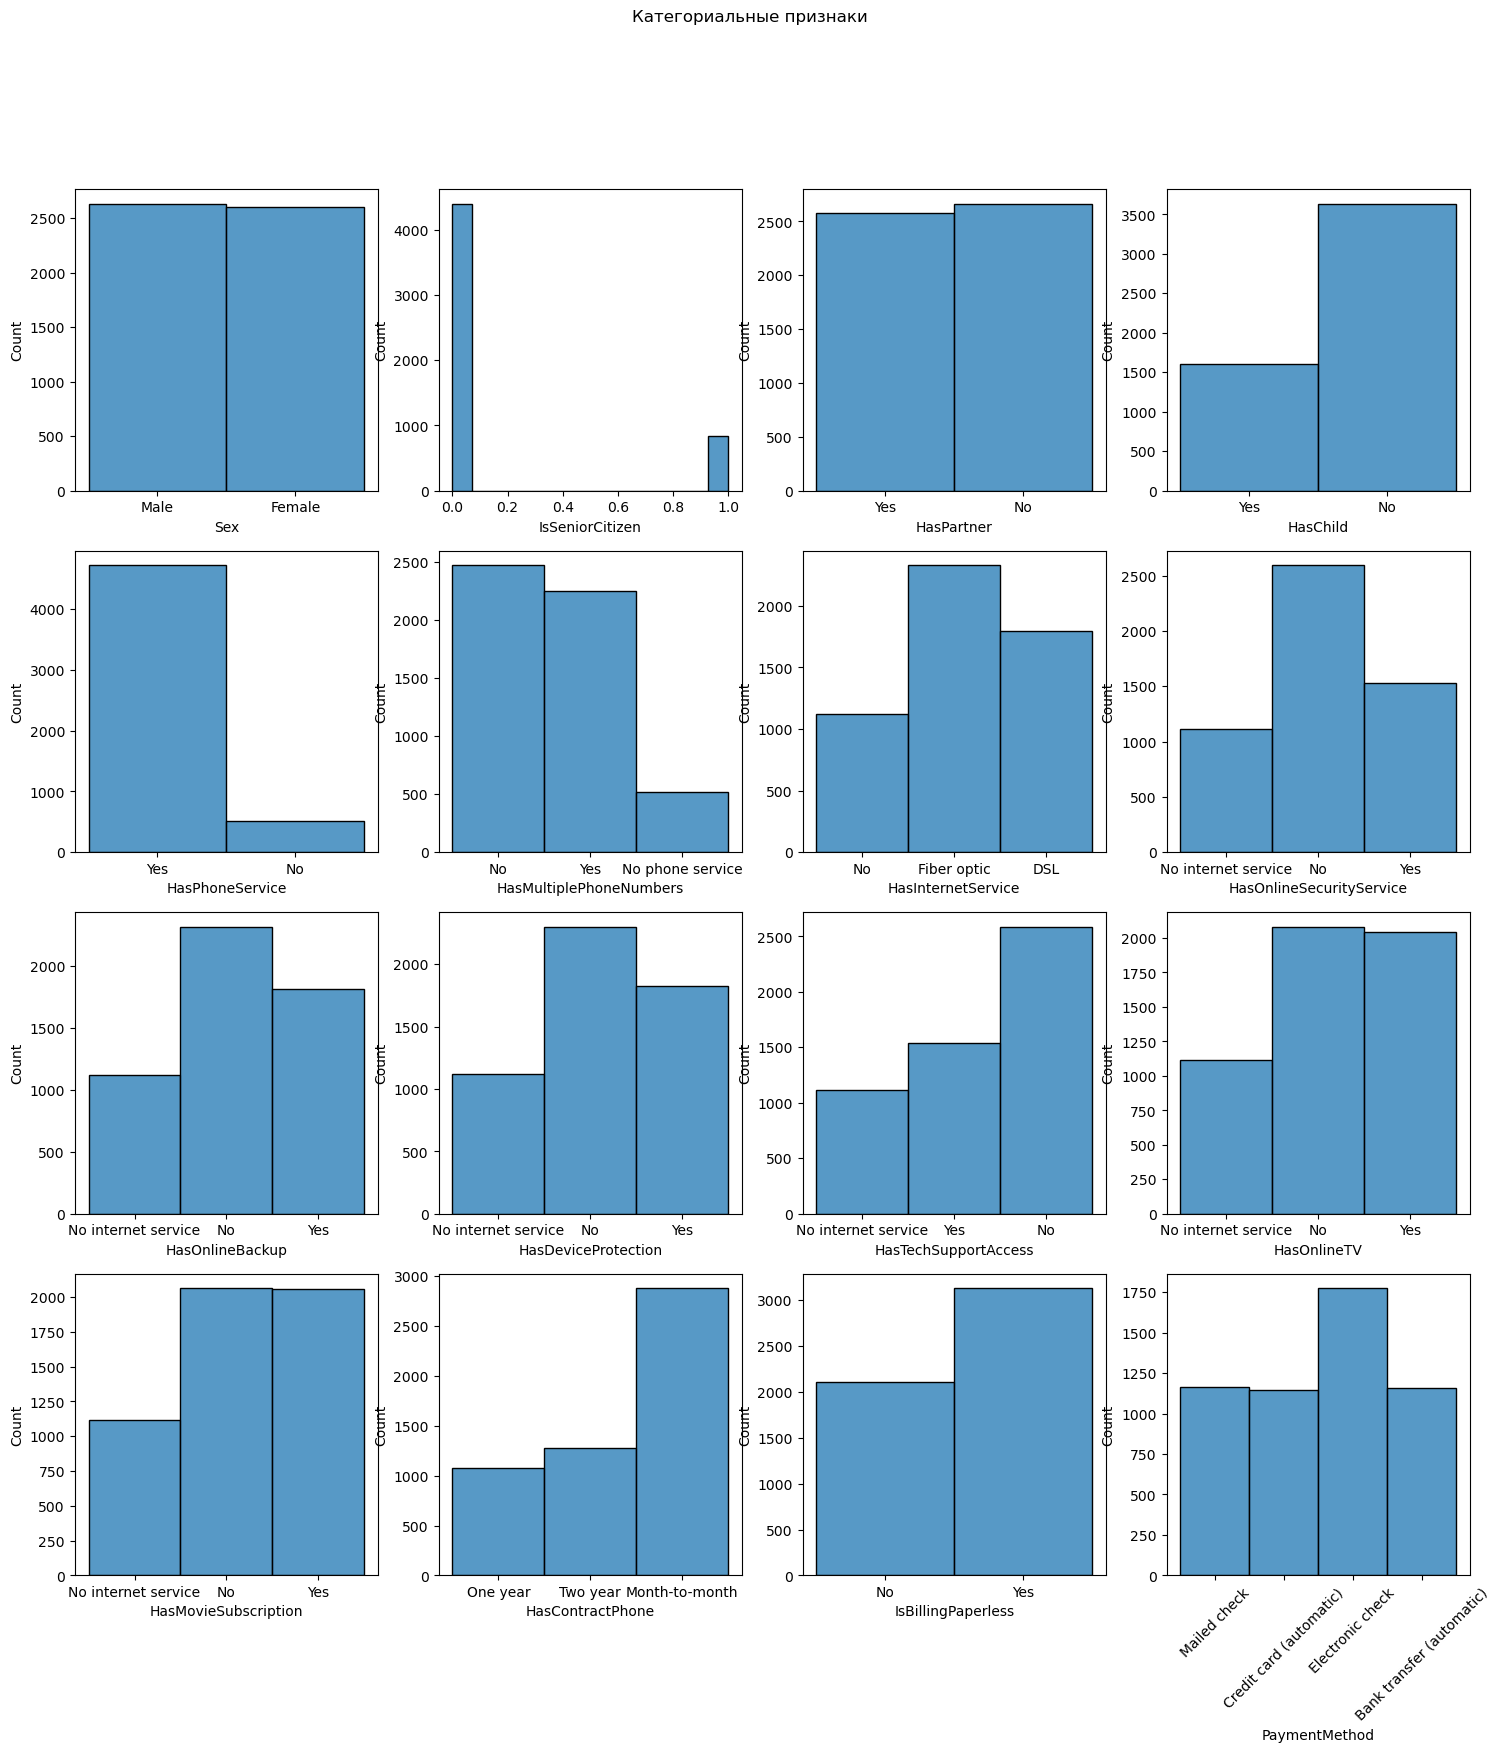

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(18, 18))

fig.suptitle("Категориальные признаки")

for j in range(4):
  for i in range(4):
    sns.histplot(ax=axes[i, j], data=train_df, x=cat_cols[4 * i + j])
plt.xticks(rotation=45)

fig.show();

In [19]:
sns.pairplot(train_df);

## Преобразование данных

In [20]:
ohk_train = pd.concat((train_df[num_cols + [target_col]], pd.get_dummies(train_df[cat_cols])), axis=1)
ohk_test = pd.concat((test_df[num_cols], pd.get_dummies(test_df[cat_cols])), axis=1)

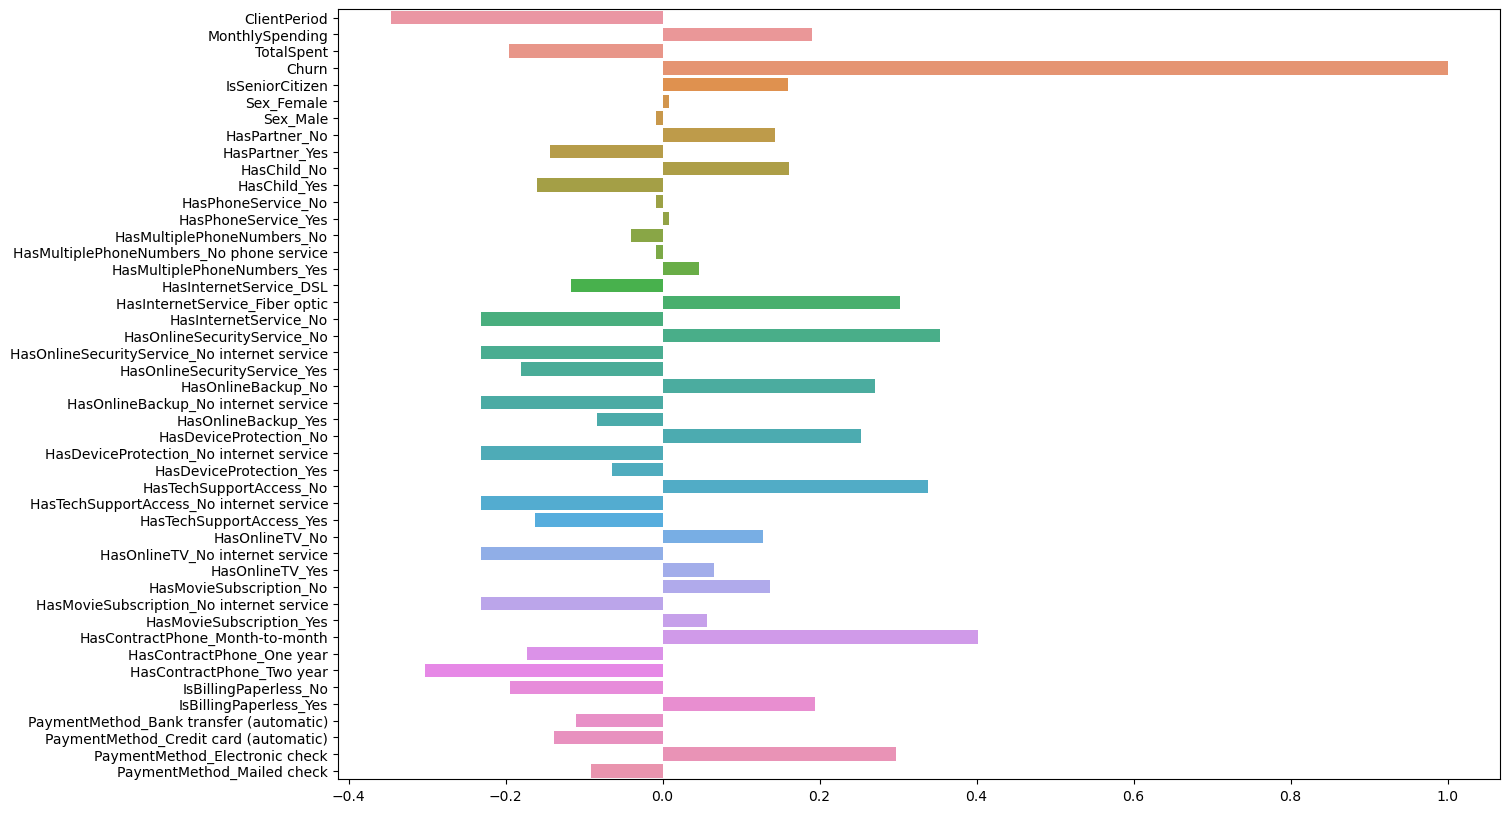

In [21]:
corr = ohk_train.corrwith(ohk_train[target_col])

plot = sns.barplot(y=corr.index, x=corr)
plot.figure.set_size_inches(15, 10)

## Линейные модели

In [22]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(
    ohk_train.drop(target_col, axis=1),
    ohk_train[target_col],
    test_size=0.2,
    random_state=RANDOM_STATE,
)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
ohk_test[num_cols] = scaler.transform(ohk_test[num_cols])

print(X_train.shape, X_val.shape)
X_train.head()

(4192, 45) (1049, 45)


,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1829,-0.551403,1.276937,-0.120443,0,0,1,0,1,0,1,...,1,1,0,0,1,0,0,0,1,0
1099,-0.551403,-0.291072,-0.552869,0,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4513,1.609584,1.464633,2.469474,0,0,1,0,1,1,0,...,1,0,0,1,0,1,0,1,0,0
4256,-1.203777,0.193948,-0.909948,0,0,1,1,0,0,1,...,1,1,0,0,1,0,0,0,0,1
2774,-1.122230,-1.455451,-0.959340,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1


In [23]:
def plot_curve(model):
    y_train_predicted = model.predict_proba(X_train)[:, 1]
    y_valid_predicted = model.predict_proba(X_val)[:, 1]
    
    train_auc = metrics.roc_auc_score(y_train, y_train_predicted)
    valid_auc = metrics.roc_auc_score(y_val, y_valid_predicted)

    plt.figure(figsize=(20,10))
    plt.plot(*metrics.roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*metrics.roc_curve(y_val, y_valid_predicted)[:2], label='valid AUC={:.4f}'.format(valid_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

In [24]:
params ={
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'C': np.linspace(0.001, 0.5, num=6),
    'max_iter': [1000],
#     'n_jobs': [-1],
}

model = linear_model.LogisticRegression(random_state=RANDOM_STATE)
search = model_selection.GridSearchCV(
    model,
    param_grid=params,
    cv=5,
    scoring='roc_auc'
)

search.fit(X_train, y_train)

print(f"\nЛучшие параметры: {search.best_params_}")


Лучшие параметры: {'C': 0.5, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


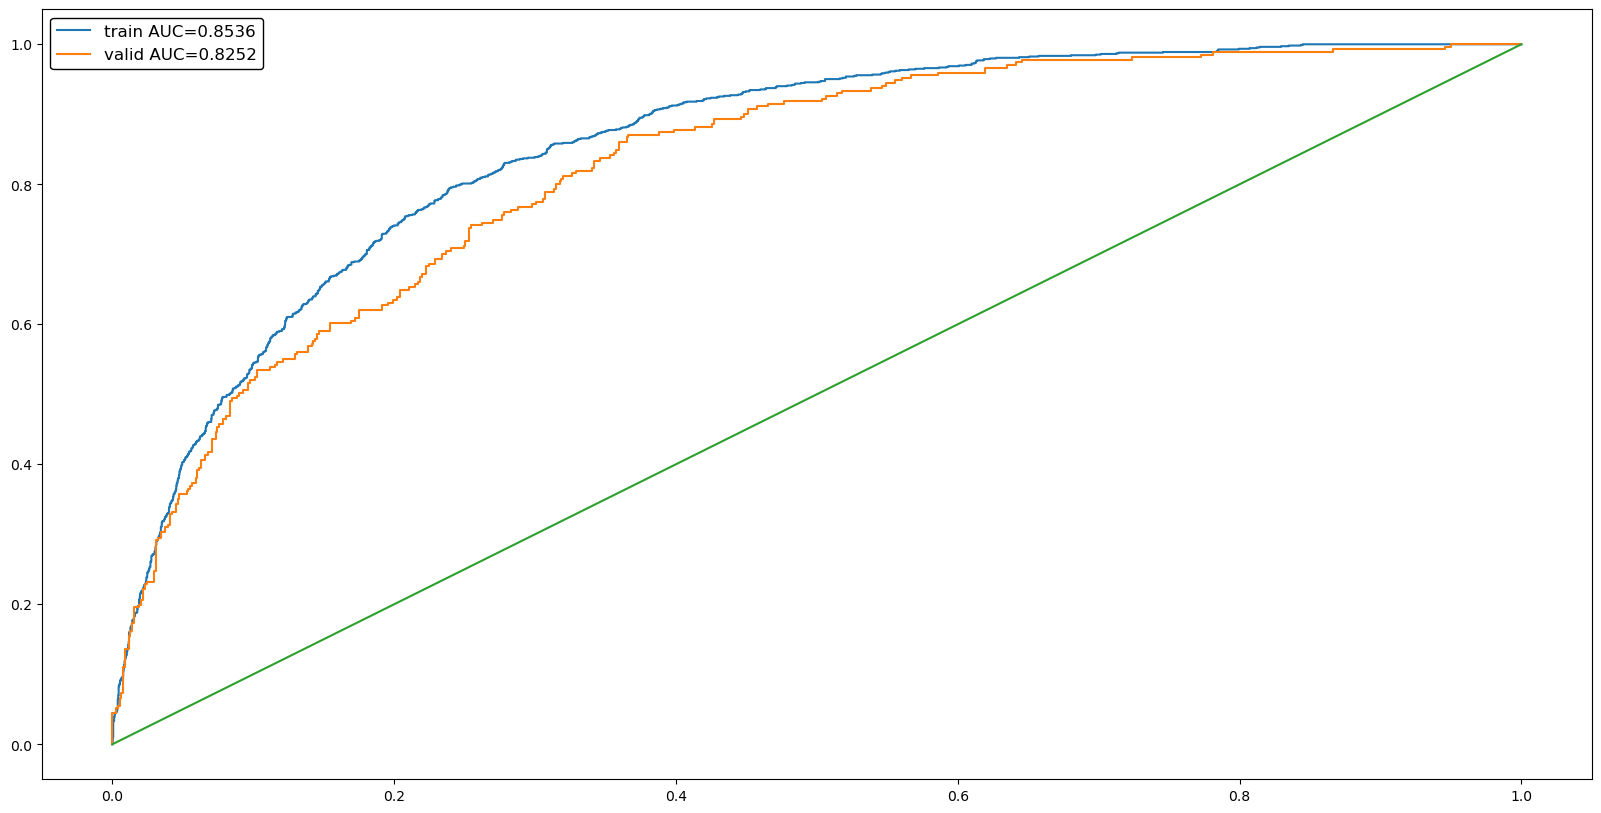

In [25]:
best_model = search.best_estimator_
best_model.fit(X_train, y_train)

plot_curve(best_model)

In [26]:
pred = best_model.predict_proba(ohk_test)[:, 1]
logreg_submission = pd.DataFrame({"Churn": pred})
logreg_submission["Id"] = logreg_submission.index
logreg_submission = logreg_submission[["Id", "Churn"]]
logreg_submission.to_csv("LinearModelSubmission.csv", index=False)

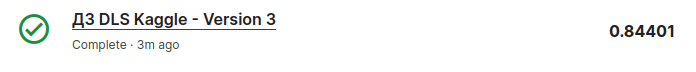

## Градиентный бустинг

Воспользуемся optuna для нахождения лучших параметров CatBoostClassifier

In [36]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(
    train_df.drop(target_col, axis=1),
    train_df[target_col],
    test_size=0.2,
    random_state=RANDOM_STATE,
)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
ohk_test[num_cols] = scaler.transform(ohk_test[num_cols])


def objective(trial):
    
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int('iterations', 80, 1500),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        depth=trial.suggest_int('depth', 1, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        cat_features=cat_cols,
        verbose=0,
        random_state=RANDOM_STATE,
    )
    
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_val)[:, 1]
    return metrics.roc_auc_score(y_val, pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2023-03-20 14:31:20,893] A new study created in memory with name: no-name-d858a8de-94ab-403d-aa5b-aa7a4fa88b8d
[I 2023-03-20 14:31:35,347] Trial 0 finished with value: 0.8132974131797873 and parameters: {'iterations': 677, 'learning_rate': 0.02594864296584595, 'depth': 7, 'l2_leaf_reg': 7.298272696056389, 'bootstrap_type': 'Bayesian', 'random_strength': 1.016336045352783e-07, 'bagging_temperature': 1.9680168089823757, 'od_type': 'Iter', 'od_wait': 21}. Best is trial 0 with value: 0.8132974131797873.
[I 2023-03-20 14:31:38,827] Trial 1 finished with value: 0.7958977983096026 and parameters: {'iterations': 198, 'learning_rate': 0.1463603009504447, 'depth': 10, 'l2_leaf_reg': 67.55803371524877, 'bootstrap_type': 'Bayesian', 'random_strength': 3.202598170721859e-07, 'bagging_temperature': 4.887323039857221, 'od_type': 'Iter', 'od_wait': 20}. Best is trial 0 with value: 0.8132974131797873.
[I 2023-03-20 14:31:39,560] Trial 2 finished with value: 0.8106911467572259 and parameters: {'itera

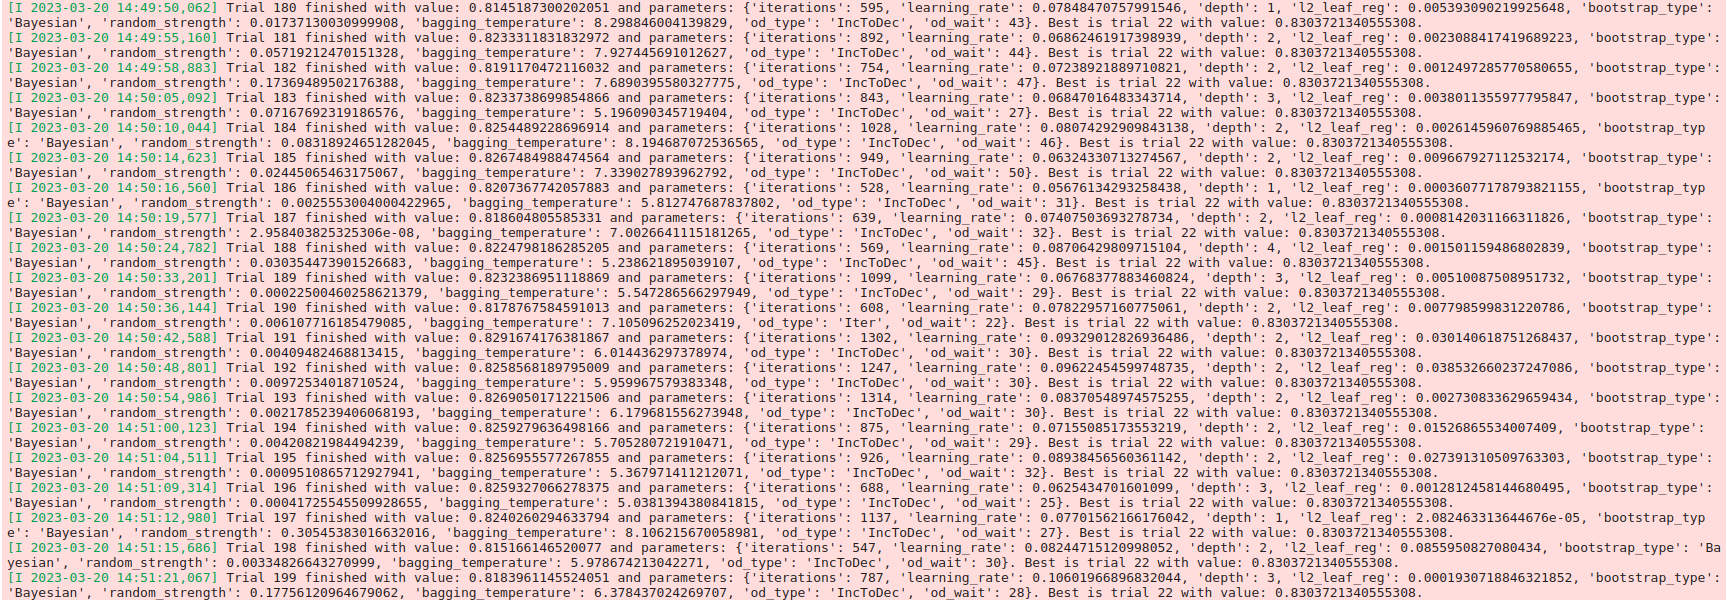

In [37]:
print(f"Лучшие параметры: {study.best_params}")

Лучшие параметры: {'iterations': 1160, 'learning_rate': 0.08505207226362868, 'depth': 2, 'l2_leaf_reg': 0.009922662869818067, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00018902211761677885, 'bagging_temperature': 7.905257077882812, 'od_type': 'IncToDec', 'od_wait': 32}


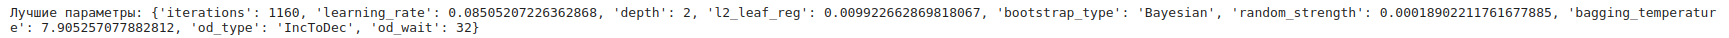

In [40]:
X = train_df.drop(target_col, axis=1)
y = train_df[target_col]

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

model = catboost.CatBoostClassifier(
        iterations=1160,
        learning_rate=0.08505207226362868,
        depth=2,
        cat_features=cat_cols,
        eval_metric='AUC',
        l2_leaf_reg=0.009922662869818067,
        bootstrap_type='Bayesian',
        random_strength=0.00018902211761677885,
        bagging_temperature=7.905257077882812,
        od_type='IncToDec',
        od_wait=32,
        verbose=0,
        random_state=RANDOM_STATE,
    )

model.fit(X_train, y_train, verbose=False)

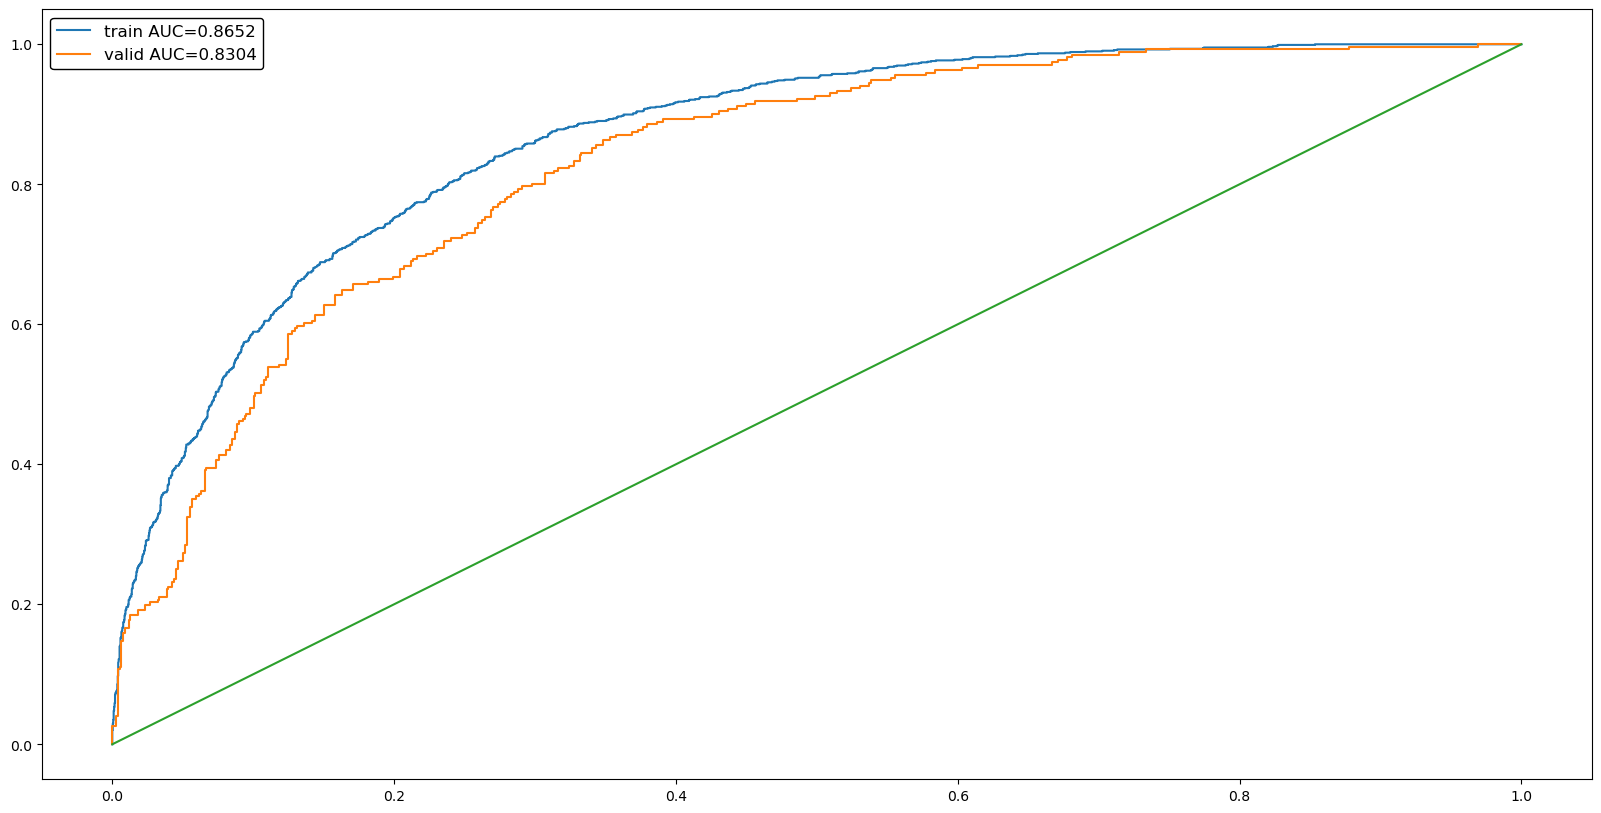

In [41]:
plot_curve(model)

In [31]:
model.fit(X, y)

In [42]:
pred = model.predict_proba(test_df)[:, 1]
cbsbm = pd.DataFrame({"Churn": pred})
cbsbm["Id"] = cbsbm.index
cbsbm = cbsbm[["Id", "Churn"]]
cbsbm.to_csv("CatBoostSubmission.csv", index=False)

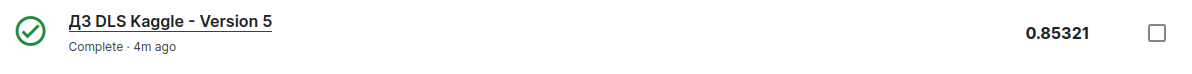